In [13]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
image_dir = r"C:\Users\V Varunkumar\Desktop\DM 4\Cropped"  
batch_size = 32
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = ImageFolder(image_dir, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
model = resnet18(pretrained=True)
model.eval()
def hook_fn(module, input, output):
    batch_features = output.view(output.size(0), -1)  
    features.append(batch_features.detach().cpu())
features = []
hook = model.layer4.register_forward_hook(hook_fn)
with torch.no_grad():
    for images, _ in data_loader:
        images = images.cuda() if torch.cuda.is_available() else images
        _ = model(images)  
hook.remove()
features = torch.cat(features, dim=0) 
print(f"Extracted features shape: {features.shape}")





c:\Users\V Varunkumar\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\V Varunkumar\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracted features shape: torch.Size([769, 25088])


https://kozodoi.me/blog/20210527/extracting-features. 

Performing PCA for dimension reduction...
Reduced features shape: (769, 2)


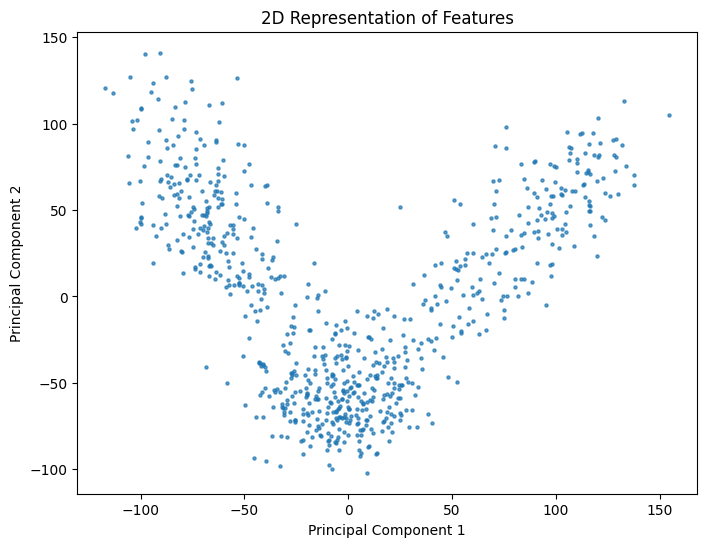

In [14]:

print("Performing PCA for dimension reduction...")
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)
print(f"Reduced features shape: {reduced_features.shape}")
plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], s=5, alpha=0.7)
plt.title("2D Representation of Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

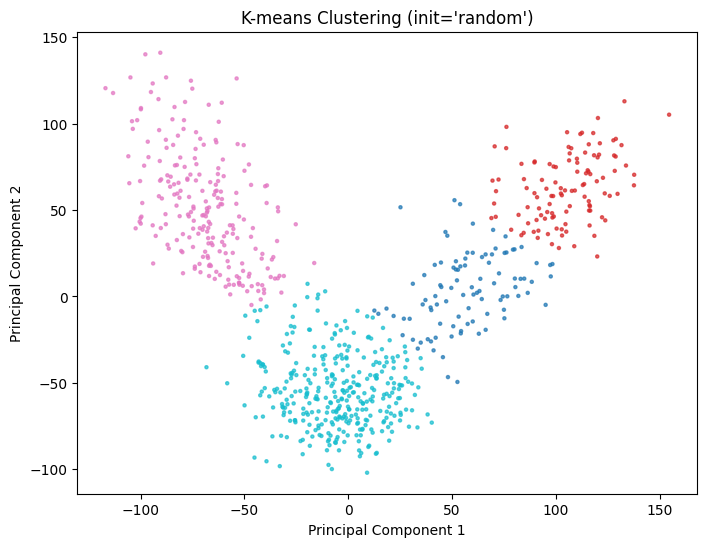

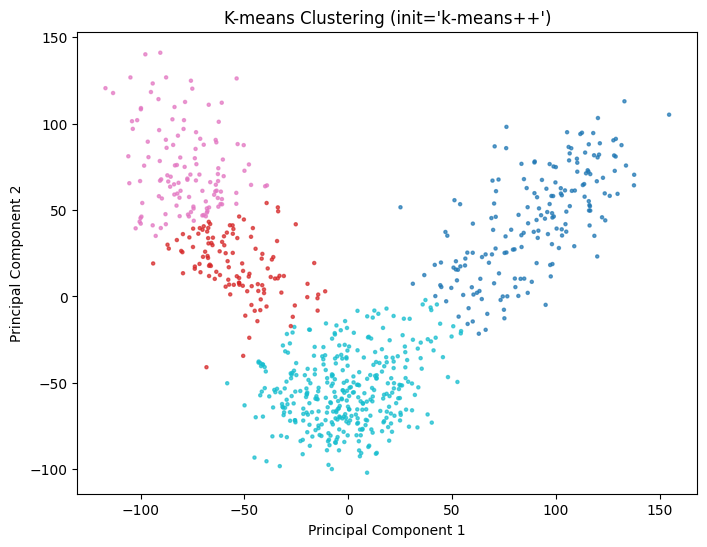

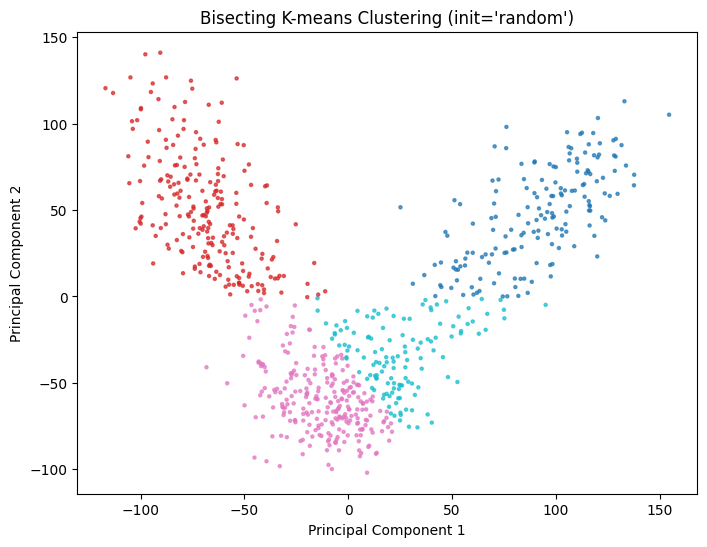

C:\Users\V Varunkumar\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


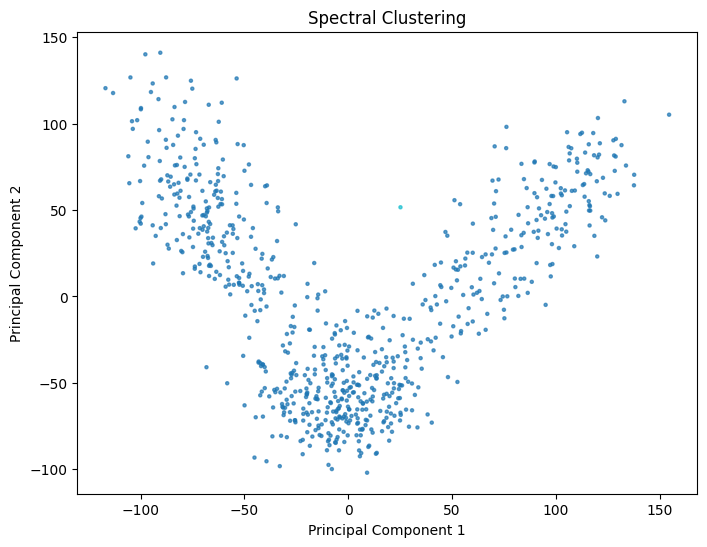

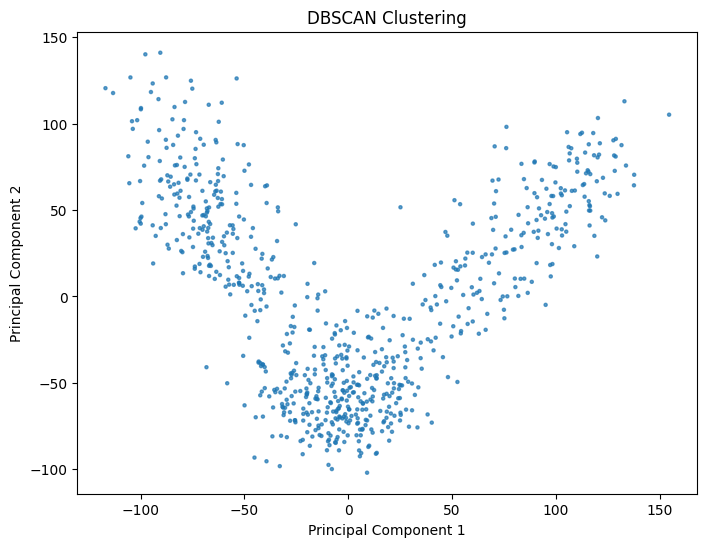

DBSCAN eps: 0.2 min_samples: 5


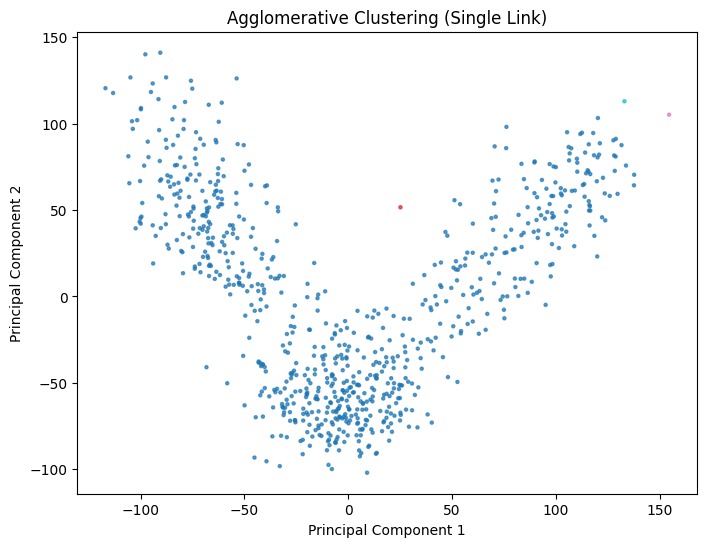

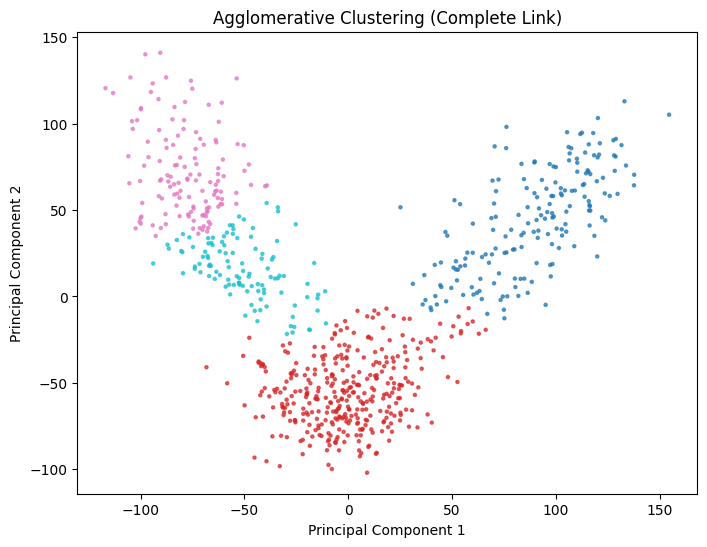

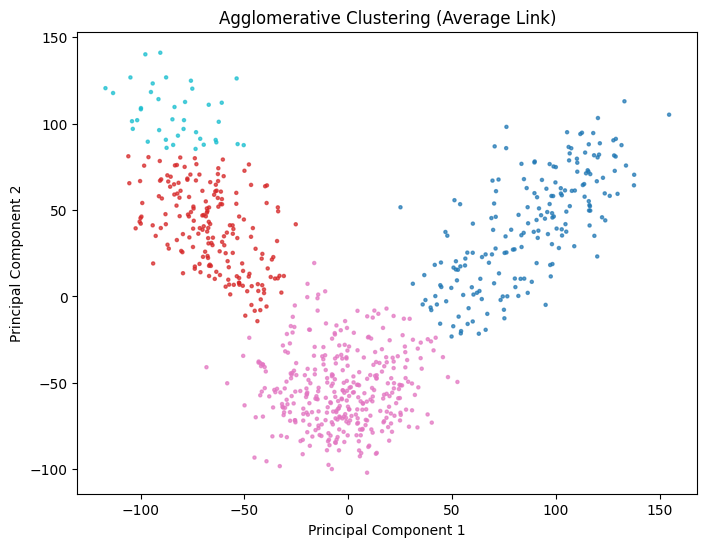

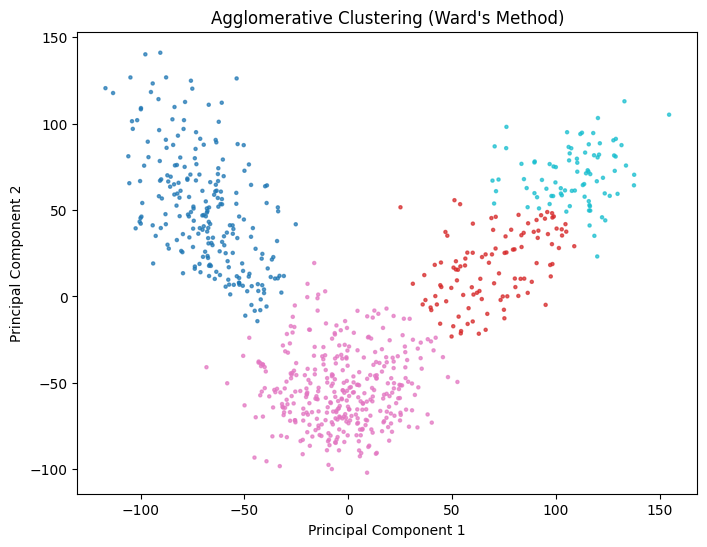

In [ ]:
import numpy as np
from sklearn.cluster import KMeans, BisectingKMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
import matplotlib.pyplot as plt
def plot_clusters(data, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10', s=5, alpha=0.7)
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

#K-means clustering with init=random
kmeans_random = KMeans(n_clusters=4, init='random', random_state=42)
labels_kmeans_random = kmeans_random.fit_predict(reduced_features)
plot_clusters(reduced_features, labels_kmeans_random, "K-means Clustering (init='random')")

#K-means clustering with init=k-means++
kmeans_kmeanspp = KMeans(n_clusters=4, init='k-means++', random_state=42)
labels_kmeans_kmeanspp = kmeans_kmeanspp.fit_predict(reduced_features)
plot_clusters(reduced_features, labels_kmeans_kmeanspp, "K-means Clustering (init='k-means++')")

#Bisecting K-means clustering with init=random
bisecting_kmeans = BisectingKMeans(n_clusters=4, init='random', random_state=42)
labels_bisecting_kmeans = bisecting_kmeans.fit_predict(reduced_features)
plot_clusters(reduced_features, labels_bisecting_kmeans, "Bisecting K-means Clustering (init='random')")

#Spectral clustering
spectral_clustering = SpectralClustering(n_clusters=4, random_state=42)
labels_spectral = spectral_clustering.fit_predict(reduced_features)
plot_clusters(reduced_features, labels_spectral, "Spectral Clustering")

#DBSCAN
# Using eps and min_samples values that create 4 clusters
dbscan = DBSCAN(eps=0.2, min_samples=5)
labels_dbscan = dbscan.fit_predict(reduced_features)
plot_clusters(reduced_features, labels_dbscan, "DBSCAN Clustering")

# Print the eps and min_samples values for DBSCAN
print("DBSCAN eps:", 0.2, "min_samples:", 5)

# Agglomerative Clustering
#(MIN)
agg_single = AgglomerativeClustering(n_clusters=4, linkage='single')
labels_agg_single = agg_single.fit_predict(reduced_features)
plot_clusters(reduced_features, labels_agg_single, "Agglomerative Clustering (Single Link)")

#(MAX)
agg_complete = AgglomerativeClustering(n_clusters=4, linkage='complete')
labels_agg_complete = agg_complete.fit_predict(reduced_features)
plot_clusters(reduced_features, labels_agg_complete, "Agglomerative Clustering (Complete Link)")

# Group Average
agg_average = AgglomerativeClustering(n_clusters=4, linkage='average')
labels_agg_average = agg_average.fit_predict(reduced_features)
plot_clusters(reduced_features, labels_agg_average, "Agglomerative Clustering (Average Link)")

# Ward's method
agg_ward = AgglomerativeClustering(n_clusters=4, linkage='ward')
labels_agg_ward = agg_ward.fit_predict(reduced_features)
plot_clusters(reduced_features, labels_agg_ward, "Agglomerative Clustering (Ward's Method)")


In [ ]:
from sklearn.metrics import fowlkes_mallows_score, silhouette_score
import numpy as np
true_labels = []
with torch.no_grad():
    for _, labels in data_loader:
        true_labels.extend(labels.numpy())  
true_labels = np.array(true_labels)  
def evaluate_clustering_metrics(true_labels, predicted_labels, features):
    if len(true_labels) != len(predicted_labels):
        raise ValueError("The length of true_labels and predicted_labels must match.")
    if len(predicted_labels) == 0:
        raise ValueError("No valid points left for evaluation after filtering.")
    fmi = fowlkes_mallows_score(true_labels, predicted_labels)
    silhouette = silhouette_score(features, predicted_labels)
    return fmi, silhouette

evaluation_results = {}

# K-means clustering with init=random
fmi_kmeans_random, silhouette_kmeans_random = evaluate_clustering_metrics(true_labels, labels_kmeans_random, reduced_features)
evaluation_results['K-means (init=random)'] = (fmi_kmeans_random, silhouette_kmeans_random)

# K-means clustering with init=k-means++
fmi_kmeans_kmeanspp, silhouette_kmeans_kmeanspp = evaluate_clustering_metrics(true_labels, labels_kmeans_kmeanspp, reduced_features)
evaluation_results['K-means (init=k-means++)'] = (fmi_kmeans_kmeanspp, silhouette_kmeans_kmeanspp)

# Bisecting K-means clustering with init=random
fmi_bisecting_kmeans, silhouette_bisecting_kmeans = evaluate_clustering_metrics(true_labels, labels_bisecting_kmeans, reduced_features)
evaluation_results['Bisecting K-means (init=random)'] = (fmi_bisecting_kmeans, silhouette_bisecting_kmeans)

# Spectral clustering
fmi_spectral, silhouette_spectral = evaluate_clustering_metrics(true_labels, labels_spectral, reduced_features)
evaluation_results['Spectral Clustering'] = (fmi_spectral, silhouette_spectral)

# DBSCAN clustering
if -1 in labels_dbscan:
    mask = labels_dbscan != -1
    if np.any(mask):  
        true_labels_dbscan = np.array(true_labels)[mask]
        labels_dbscan_filtered = labels_dbscan[mask]
        if len(true_labels_dbscan) == len(labels_dbscan_filtered):
            fmi_dbscan, silhouette_dbscan = evaluate_clustering_metrics(true_labels_dbscan, labels_dbscan_filtered, reduced_features)
            evaluation_results['DBSCAN'] = (fmi_dbscan, silhouette_dbscan)
        else:
            print("Mismatch after DBSCAN filtering: lengths of true_labels and labels_dbscan don't match.")
    else:
        print("All points are labeled as noise in DBSCAN.")
else:
    if len(true_labels) == len(labels_dbscan):
        fmi_dbscan, silhouette_dbscan = evaluate_clustering_metrics(true_labels, labels_dbscan, reduced_features)
        evaluation_results['DBSCAN'] = (fmi_dbscan, silhouette_dbscan)
    else:
        print("Mismatch between true_labels and DBSCAN labels before filtering.")
fmi_agg_single, silhouette_agg_single = evaluate_clustering_metrics(true_labels, labels_agg_single, reduced_features) # type: ignore
evaluation_results['Agglomerative (Single Link)'] = (fmi_agg_single, silhouette_agg_single)
fmi_agg_complete, silhouette_agg_complete = evaluate_clustering_metrics(true_labels, labels_agg_complete, reduced_features)
evaluation_results['Agglomerative (Complete Link)'] = (fmi_agg_complete, silhouette_agg_complete)
fmi_agg_average, silhouette_agg_average = evaluate_clustering_metrics(true_labels, labels_agg_average, reduced_features)
evaluation_results['Agglomerative (Average Link)'] = (fmi_agg_average, silhouette_agg_average)
fmi_agg_ward, silhouette_agg_ward = evaluate_clustering_metrics(true_labels, labels_agg_ward, reduced_features)
evaluation_results['Agglomerative (Ward)'] = (fmi_agg_ward, silhouette_agg_ward)
print("Evaluation Results (Fowlkes-Mallows Index and Silhouette Coefficient):")
for method, (fmi, silhouette) in evaluation_results.items():
    print(f"{method} -> FMI: {fmi:.4f}, Silhouette: {silhouette:.4f}")
print("\nRanking based on Fowlkes-Mallows Index (best to worst):")
sorted_fmi = sorted(evaluation_results.items(), key=lambda x: x[1][0], reverse=True)
for rank, (method, (fmi, _)) in enumerate(sorted_fmi, start=1):
    print(f"{rank}. {method} -> FMI: {fmi:.4f}")
print("\nRanking based on Silhouette Coefficient (best to worst):")
sorted_silhouette = sorted(evaluation_results.items(), key=lambda x: x[1][1], reverse=True)
for rank, (method, (_, silhouette)) in enumerate(sorted_silhouette, start=1):
    print(f"{rank}. {method} -> Silhouette: {silhouette:.4f}")


All points are labeled as noise in DBSCAN.
Evaluation Results (Fowlkes-Mallows Index and Silhouette Coefficient):
K-means (init=random) -> FMI: 0.7328, Silhouette: 0.5544
K-means (init=k-means++) -> FMI: 0.6910, Silhouette: 0.5295
Bisecting K-means (init=random) -> FMI: 0.7390, Silhouette: 0.4589
Spectral Clustering -> FMI: 0.5026, Silhouette: -0.0409
Agglomerative (Single Link) -> FMI: 0.5014, Silhouette: -0.0628
Agglomerative (Complete Link) -> FMI: 0.6921, Silhouette: 0.5162
Agglomerative (Average Link) -> FMI: 0.7602, Silhouette: 0.5559
Agglomerative (Ward) -> FMI: 0.7498, Silhouette: 0.5598

Ranking based on Fowlkes-Mallows Index (best to worst):
1. Agglomerative (Average Link) -> FMI: 0.7602
2. Agglomerative (Ward) -> FMI: 0.7498
3. Bisecting K-means (init=random) -> FMI: 0.7390
4. K-means (init=random) -> FMI: 0.7328
5. Agglomerative (Complete Link) -> FMI: 0.6921
6. K-means (init=k-means++) -> FMI: 0.6910
7. Spectral Clustering -> FMI: 0.5026
8. Agglomerative (Single Link) -> F